## Final Model Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helper_functions import (train_and_evaluate_model, 
                              calculate_returns_for_predictions, 
                              calculate_metrics, 
                              calculate_returns_for_model)

In [2]:
import os
os.chdir(os.path.expanduser('../classical_models'))
import hierarchical_risk_parity as hrp

In [3]:
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [4]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
df_returns = df_countries.pct_change().dropna()
days_to_recalculate = data_provider.get_days_to_recalculate()

### Risk Parity Model

In [5]:
def get_risk_parity_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)
    days_no = 126 # Six months

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-days_no:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_risk_parity_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [6]:
test_split = int(0.8 * 288)
dates_for_test = days_to_recalculate[test_split:]
weights_risk_parity = get_risk_parity_weights(df_returns, dates_for_test)

### DNN Model

In [7]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.regularizers import L2

In [8]:
x = data_provider.get_formatted_features(no_months=6, flatten=True)
y = data_provider.get_formatted_targets()
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

In [9]:
final_dnn_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Dense(64, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(final_dnn_model, x_train, y_train, x_val, y_val, 
                         x_test, y_test, verbose=False)

Train error: 0.0005354367895051837
Val error: 0.00056193966884166
Test error: 0.0009649894200265408
Execution time 4.59 seconds


### Backtesting

In [10]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [11]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [12]:
total_returns_risk_parity, cum_total_returns_risk_parity = calculate_returns_for_predictions(
    weights_risk_parity, dates_for_test, df_returns_test)

In [13]:
(total_returns_dnn_model, cum_total_returns_dnn_model) = calculate_returns_for_model(
    final_dnn_model, x_test, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


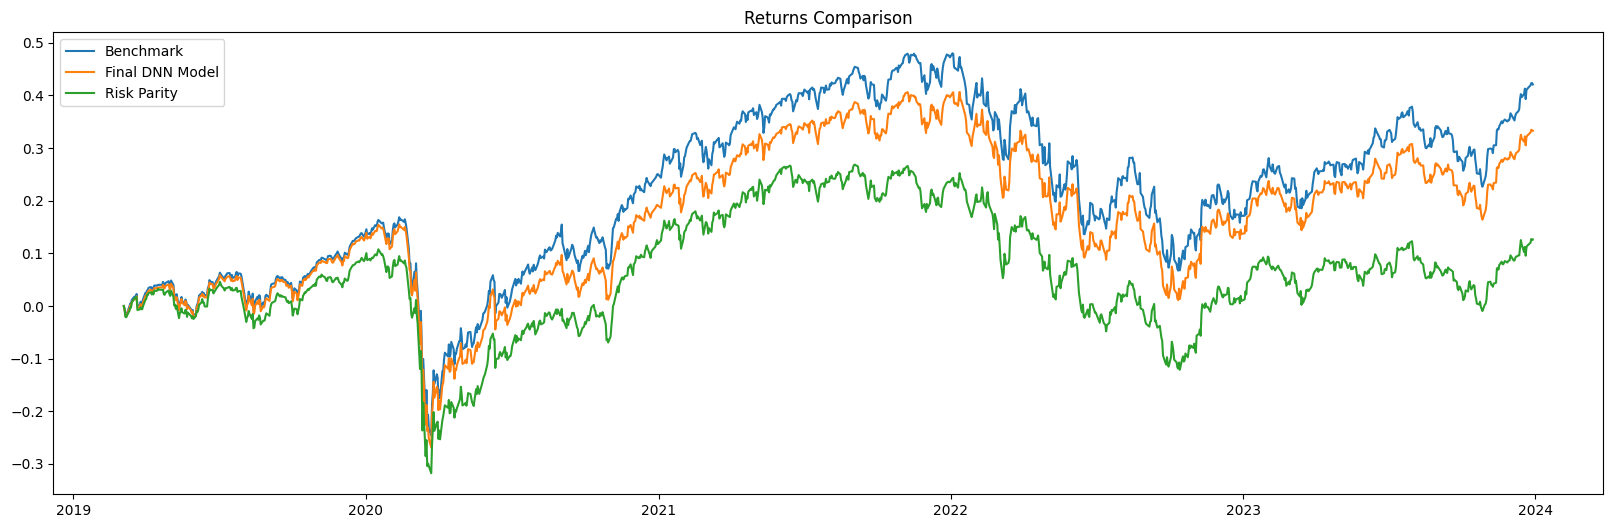

In [16]:
plt.figure(figsize=(20, 6))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_dnn_model, label='Final DNN Model')
plt.plot(cum_total_returns_risk_parity, label='Risk Parity')
plt.legend()
plt.title('Returns Comparison')
plt.show()

In [17]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_dnn_model, df_results, 'Final DNN Model', benchmark_returns)
calculate_metrics(total_returns_risk_parity, df_results, 'Risk Parity', benchmark_returns)

df_results = df_results.astype(float).round(4)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.4420,-0.3548,500.0,0.2163,0.0000
Final DNN Model,0.0621,0.2015,0.3081,0.3571,-0.3671,493.0,0.1691,-0.5525
Risk Parity,0.0256,0.1985,0.1289,0.1458,-0.3841,583.0,0.0666,-0.8046
